# Confronto tra DGV-PTTOT e DGV-PTTOT-S
Di seguito, confrontiamo il modello ottimizzato (HP tuning con 100 esperimenti) usando tutto il dataset per DGV-PTTOT e il modello ottimizzato usando il sottoinsieme del precedente dataset (HP tuning con 500 esperimenti). Entrambi i modelli sono riaddestrati e testati usando rispettivamente il training e il test set completo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
import os.path
sns.set_theme(style="whitegrid")

train_df = pd.read_csv("data/input/DGV_PTTOT_train.csv")
test_df = pd.read_csv("data/input/DGV_PTTOT_test.csv")
all_df = pd.concat([train_df, test_df])

Addestro il modello DGV-PTTOT (o carico i risultati, se l'ho già eseguito):

In [2]:
train_res_tot_file = "data/output/DGV_PTTOT_train_result.csv"
test_res_tot_file = "data/output/DGV_PTTOT_test_result.csv"

if os.path.exists(train_res_tot_file) and os.path.exists(test_res_tot_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGV_PTTOT.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_tot = model.fit(data, best_epoch)
    test_res_tot = model.test(data)
    train_res_tot.to_csv(train_res_tot_file, index=False)
    test_res_tot.to_csv(test_res_tot_file, index=False)
    
train_res_tot = pd.read_csv(train_res_tot_file)
test_res_tot = pd.read_csv(test_res_tot_file)

Carico i risultati del modello da file


Addestro il modello DGV-PTTOT-S (o carico i risultati, se l'ho già eseguito):

In [3]:
train_res_par_file = "data/output/DGV_PTTOT_S_ALL_train_result.csv"
test_res_par_file = "data/output/DGV_PTTOT_S_ALL_test_result.csv"

if os.path.exists(train_res_par_file) and os.path.exists(test_res_par_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGV_PTTOT_S.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_df, None, test_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_par = model.fit(data, best_epoch)
    test_res_par = model.test(data)
    train_res_par.to_csv(train_res_par_file, index=False)
    test_res_par.to_csv(test_res_par_file, index=False)
    
train_res_par = pd.read_csv(train_res_par_file)
test_res_par = pd.read_csv(test_res_par_file)

Carico i risultati del modello da file


Possiamo notare come il modello DGV-PTTOT-S si comporti in modo lievemente peggiore ma analogo rispetto al modello DGV-PTTOT.

In [4]:
test_res_tot["abs_err"] = (test_res_tot.target - test_res_tot.prediction).abs()
test_res_tot["rel_err"] = test_res_tot.abs_err / test_res_tot.target
test_res_tot["residual"] = test_res_tot.target - test_res_tot.prediction
test_res_tot[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,139000.000000,1.390000e+05
mean,52.583493,3.339884e-02
std,153.926033,4.604786e-02
min,0.000011,4.348473e-07
25%,3.504526,9.946890e-03
50%,11.202888,2.182245e-02
75%,37.587463,4.003703e-02
max,6012.777344,7.752898e-01


In [5]:
test_res_par["abs_err"] = (test_res_par.target - test_res_par.prediction).abs()
test_res_par["rel_err"] = test_res_par.abs_err / test_res_par.target
test_res_par["residual"] = test_res_par.target - test_res_par.prediction
test_res_par[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,139000.000000,139000.000000
mean,64.923353,0.042130
std,172.982417,0.066917
min,0.000000,0.000000
25%,4.190115,0.012162
50%,13.578278,0.026635
75%,48.873077,0.049256
max,4325.542969,1.043069


In [6]:
for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE DGV-PTTOT: 52.5834932143208
MAE DGV-PTTOT-S: 64.92335280106565


In [7]:
for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE DGV-PTTOT: 162.659389709988
RMSE DGV-PTTOT-S: 184.7640195449011


In [8]:
for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE DGV-PTTOT: 3.339884130376464
MAPE DGV-PTTOT-S: 4.213042934957242


Anche analizzando la distribuzione dell'errore notiamo una forte somiglianza.

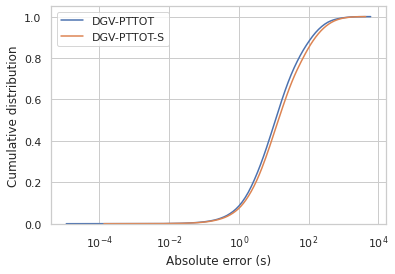

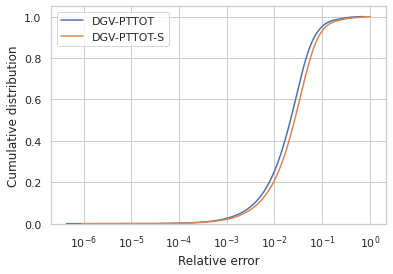

In [9]:
for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pttot-pttot-s/cdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("rel_err > 0"), x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgv-pttot-pttot-s/cdf-errore-relativo.pdf")
plt.show()

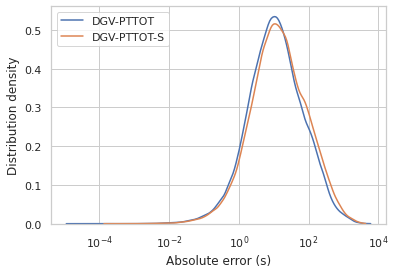

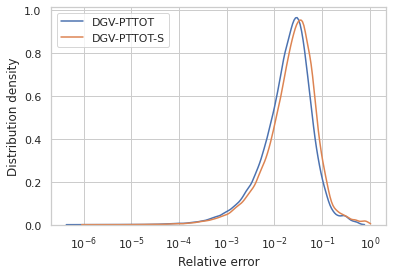

In [10]:
for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="abs_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgv-pttot-pttot-s/pdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("DGV-PTTOT", "DGV-PTTOT-S"), (test_res_tot, test_res_par)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="rel_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgv-pttot-pttot-s/pdf-errore-relativo.pdf")
plt.show()

I due modelli sono abbastanza simili.

In [11]:
with open("data/hpopt/DGV_PTTOT.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial
        
    config = best["result"]["config"]
    print("Modello DGV-PTTOT")
    print(yaml.dump(config))
    
with open("data/hpopt/DGV_PTTOT_S.pk", "rb") as fp:
    trials = pickle.load(fp)
    best = trials.best_trial
        
    config = best["result"]["config"]
    print("Modello DGV-PTTOT-S")
    print(yaml.dump(config))

Modello DGV-PTTOT
batch: 256
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 47
  - dropout: 0.0
    size: 49
  - dropout: 0.0
    size: 40
optimizer:
  lr: 0.0038099215615586793
  name: adam
  weight_decay: 0.03490142737360863

Modello DGV-PTTOT-S
batch: 64
epochs: 500
kfold: 10
loss: mae
model:
  layers: !!python/tuple
  - dropout: 0.0
    size: 42
  - dropout: 0.0
    size: 24
  - dropout: 0.0
    size: 54
optimizer:
  lr: 0.0014092384643065352
  name: adam
  weight_decay: 0.06052921153575907



## Conclusioni
I due modelli hanno prestazioni analoghe, ma DGV-PTTOT è lievemente migliore. Si può concludere che:
- il maggior numero di esperimenti pesa meno del minor numero di dati
- il sostanziale minor numero di dati usato nell'HP tuning di DGV-PTTOT-S non influisce drasticamente sulla qualità del modello, probabilmente perché il modello riesce ad apprendere molto facilmente una relazione sostanzialmente lineare tra il numero di ore e il tempo di esecuzione per una data configurazione.

Tuttavia, possiamo notare che il tempo speso per l'HP tuning di DGV-PTTOT è sensibilmente maggiore di quello speso per DGV-PTTOT-S.

In [12]:
from datetime import timedelta
with open("data/hpopt/DGV_PTTOT.pk", "rb") as fp:
    trials = pickle.load(fp)
    total_time = timedelta(0)
    for t in trials.trials:
        total_time += t["refresh_time"] - t["book_time"]
        
print(f"DGV-PTTOT:   tempo totale HP tuning: {total_time}, tempo medio per esperimento: {total_time/len(trials)}, numero esperimenti: {len(trials)}")

from datetime import timedelta
with open("data/hpopt/DGV_PTTOT_S.pk", "rb") as fp:
    trials = pickle.load(fp)
    total_time = timedelta(0)
    for t in trials.trials:
        total_time += t["refresh_time"] - t["book_time"]
        
print(f"DGV-PTTOT-S: tempo totale HP tuning: {total_time}, tempo medio per esperimento: {total_time/len(trials)}, numero esperimenti: {len(trials)}")

DGV-PTTOT:   tempo totale HP tuning: 10 days, 6:28:25.145000, tempo medio per esperimento: 2:27:53.051450, numero esperimenti: 100
DGV-PTTOT-S: tempo totale HP tuning: 1 day, 22:34:46.795000, tempo medio per esperimento: 0:05:35.373590, numero esperimenti: 500
